# Proyecto Final:  Clasificación de Proteínas basada en sus secuencias de aminoácidos usando Machine Learning.

## Ciencia e Ingeniería Computacional
### **Nombres**: Luis Miranda, Iván Bozo.
### **Profesora**: Carol Moraga.

---

# 0) Preparacion del notebook y carga de los datos
La carga de datos se hará desde drive para facilitar el manejo del notebook y de los datos, ya que no son muy livianos, se dejara una celda comentada para correrla de forma local, pero debera guardar los datos que se subiran junto al codigo en el mismo directorio para poder correr el notebook

In [1]:
# Librerias a usar
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

In [2]:
# Carga de datos desde Drive (No corre de forma local)
df_seq = pd.read_csv('/content/drive/MyDrive/Universidad/LM/Proyecto CEIC/pdb_data_seq.csv')
df_char = pd.read_csv('/content/drive/MyDrive/Universidad/LM/Proyecto CEIC/pdb_data_no_dups.csv')

In [3]:
# Carga de datos de forma local (para reproducir el notebook, debe tener los datos en el mismo directorio y correr estas lineas)
#df_seq = pd.read_csv('pdb_data_seq.csv')
#df_char = pd.read_csv('pdb_data_no_dups.csv')

# 1) Filtrado y Pre Procesamiento de los datos

In [4]:
df_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 467304 entries, 0 to 467303
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        467304 non-null  object
 1   chainId            467294 non-null  object
 2   sequence           467276 non-null  object
 3   residueCount       467304 non-null  int64 
 4   macromoleculeType  432487 non-null  object
dtypes: int64(1), object(4)
memory usage: 17.8+ MB


In [5]:
df_char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141401 entries, 0 to 141400
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   structureId               141401 non-null  object 
 1   classification            141399 non-null  object 
 2   experimentalTechnique     141401 non-null  object 
 3   macromoleculeType         137636 non-null  object 
 4   residueCount              141401 non-null  int64  
 5   resolution                128589 non-null  float64
 6   structureMolecularWeight  141401 non-null  float64
 7   crystallizationMethod     96242 non-null   object 
 8   crystallizationTempK      97039 non-null   float64
 9   densityMatthews           124724 non-null  float64
 10  densityPercentSol         124749 non-null  float64
 11  pdbxDetails               118534 non-null  object 
 12  phValue                   105110 non-null  float64
 13  publicationYear           117602 non-null  f

Se tienen los dos dataset cargados actualmente, y se puede ver la informacion de sus columnas, el objetivo es poder clasificar proteinas basado en sus secuencias de aminoacidos, por lo tanto las columnas que se usaran por cada dataset seran las siguientes:
- **df_seq**: StructureId, sequence.
- **df_char**: structureId, classification, macromoleculeType.

Luego se hara un merge entre estos dos dataset, para obtener uno solo con toda la informacion que se usará y finalmente se filtrará el data set para solo obtener proteinas.

In [3]:
# Union de los dataset usando la informacion relevante para el estudio
df = pd.merge(df_char[['structureId','classification','macromoleculeType']], df_seq[['sequence','structureId']], on='structureId', how='inner')
df.head()

,structureId,classification,macromoleculeType,sequence
0,100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
1,100D,DNA-RNA HYBRID,DNA/RNA Hybrid,CCGGCGCCGG
2,101D,DNA,DNA,CGCGAATTCGCG
3,101D,DNA,DNA,CGCGAATTCGCG
4,101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [4]:
# Filtrado del dataset para solo trabajar con las proteinas
df = df[df['macromoleculeType'] == 'Protein']
df.reset_index(inplace=True, drop=True)
df.head()

,structureId,classification,macromoleculeType,sequence
0,101M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
1,102L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...
2,102M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...
3,103L,HYDROLASE(O-GLYCOSYL),Protein,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...
4,103M,OXYGEN TRANSPORT,Protein,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346325 entries, 0 to 346324
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        346325 non-null  object
 1   classification     346324 non-null  object
 2   macromoleculeType  346325 non-null  object
 3   sequence           346322 non-null  object
dtypes: object(4)
memory usage: 10.6+ MB


In [5]:
# Limpieza de datos nulos
df.dropna(axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346321 entries, 0 to 346324
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        346321 non-null  object
 1   classification     346321 non-null  object
 2   macromoleculeType  346321 non-null  object
 3   sequence           346321 non-null  object
dtypes: object(4)
memory usage: 13.2+ MB


# 2) Analisis Exploratorio de los Datos.
Ahora puede ser interesante conocer primero un poco mas a fondo como se distribuyen las clases, e informacion relevante para poder hacer un analisis mas detallado y en profundidad de los datos a clasificar.


In [6]:
class_counts = df.classification.value_counts()
print(class_counts)

HYDROLASE                            46336
TRANSFERASE                          36424
OXIDOREDUCTASE                       34321
IMMUNE SYSTEM                        15615
LYASE                                11682
                                     ...  
STRUCTURAL PROTEIN, CELL CYCLE           1
KINASE (GLYCOGEN METABOLISM)             1
SURFACE GLYCOPROTEIN                     1
IMMUNE SYSTEM,HYDROLASE INHIBITOR        1
antimicrobial                            1
Name: classification, Length: 4468, dtype: int64


Por las caracteristicas del dataset, al contar con una cantidad bastante grande de clases diferentes, y ademas notar que hay clases que tienen muy pocos datos, una buena idea seria filtrar por aquellas clases que tengan una cantidad minima de 1000 registros, para que asi los modelos de clasificacion logren reconocer estos datos.

In [7]:
types = np.asarray(class_counts[(class_counts > 1000)].index)
print(types)

['HYDROLASE' 'TRANSFERASE' 'OXIDOREDUCTASE' 'IMMUNE SYSTEM' 'LYASE'
 'HYDROLASE/HYDROLASE INHIBITOR' 'TRANSCRIPTION' 'VIRAL PROTEIN'
 'TRANSPORT PROTEIN' 'VIRUS' 'SIGNALING PROTEIN' 'ISOMERASE' 'LIGASE'
 'MEMBRANE PROTEIN' 'PROTEIN BINDING' 'STRUCTURAL PROTEIN' 'CHAPERONE'
 'STRUCTURAL GENOMICS, UNKNOWN FUNCTION' 'SUGAR BINDING PROTEIN'
 'DNA BINDING PROTEIN' 'PHOTOSYNTHESIS' 'ELECTRON TRANSPORT'
 'TRANSFERASE/TRANSFERASE INHIBITOR' 'METAL BINDING PROTEIN'
 'CELL ADHESION' 'UNKNOWN FUNCTION' 'PROTEIN TRANSPORT' 'TOXIN'
 'CELL CYCLE' 'RNA BINDING PROTEIN' 'DE NOVO PROTEIN' 'HORMONE'
 'GENE REGULATION' 'OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR' 'APOPTOSIS'
 'MOTOR PROTEIN' 'PROTEIN FIBRIL' 'METAL TRANSPORT'
 'VIRAL PROTEIN/IMMUNE SYSTEM' 'CONTRACTILE PROTEIN' 'FLUORESCENT PROTEIN'
 'TRANSLATION' 'BIOSYNTHETIC PROTEIN']


In [8]:
df = df[df.classification.isin(types)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278866 entries, 16 to 346311
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   structureId        278866 non-null  object
 1   classification     278866 non-null  object
 2   macromoleculeType  278866 non-null  object
 3   sequence           278866 non-null  object
dtypes: object(4)
memory usage: 10.6+ MB


<Axes: title={'center': 'Nro de Registros por Clase'}, xlabel='Frecuencia', ylabel='Clases'>

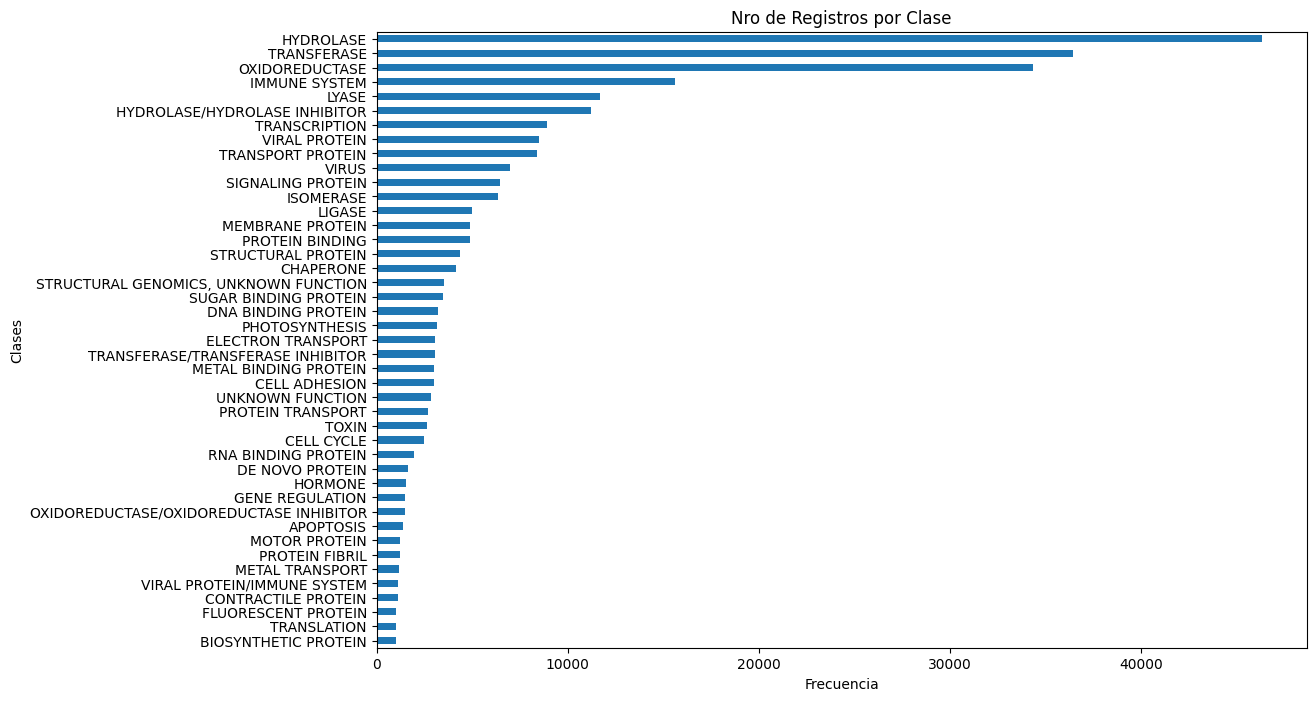

In [9]:
df.classification.value_counts().sort_values()\
.plot(kind='barh',figsize=(12,8),\
      title='Nro de Registros por Clase',\
      xlabel='Frecuencia',ylabel='Clases')

Se puede observar facilmente gracias al grafico, que hay una predominancia clara de ciertas clases en cuanto a la cantidad de muestras existentes en el dataset, las clases con mayor cantidad de registros son:
- HYDROLASE
- TRANSFERASE
- OXIDOREDUCTASE

# 3) Obtencion de los conjuntos de entrenamiento y prueba:
 Después de que el conjunto de datos ha sido filtrado, se debe llevar a cabo una división de los datos para la creación de un conjunto de entrenamiento y prueba. Tras la división de los datos, se plantea emplear CountVectorizer para la generación de un diccionario a partir del conjunto de datos de entrenamiento. De esta manera, poder lograr la extracción de caracteres individuales o conjuntos de caracteres para su uso como características.

En una proteína, no es solo el aminoácido individual el encargado de identificar su propósito. Las estructuras secundarias y terciarias se forman a través de los enlaces entre los aminoácidos presentes en la secuencia. Asimismo, diversas secciones de la cadena pueden mostrar distintos niveles de acidez o basicidad, resaltando la relevancia de utilizar características que excedan la magnitud de una unidad individual. Por consiguiente, la elección de un ngram_range de (4,4) parece una alternativa válida para la extracción de características. Esto facilitará la extracción de distintos subconjuntos con una longitud de 4, permitiendo que los aminoácidos empleen a sus vecinos para contribuir en el proceso de clasificación.

In [10]:
# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(df['sequence'], df['classification'], test_size=0.3, random_state=1)

# Crear un Count Vectorizer para reunir los elementos únicos en la secuencia
vect = CountVectorizer(analyzer='char_wb', ngram_range=(4, 4))

# Ajustar y transformar CountVectorizer
vect.fit(X_train)
X_train_df = vect.transform(X_train)
X_test_df = vect.transform(X_test)

In [11]:
# Imprimir algunas de las características
print(vect.get_feature_names_out())

[' aaa' ' aac' ' aad' ... 'zvka' 'zwdl' 'zzvb']


# 4) Modelos de Machine Learning


## 4.1 Redes Neuronales

In [16]:
# Codificar las etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [17]:
# Crear el modelo de red neuronal
model1 = Sequential([
    Dense(128, input_shape=(X_train_df.shape[1],), activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [18]:
# Compilar el modelo
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model1.fit(X_train_df, y_train_encoded, epochs=5, batch_size=32, validation_data=(X_test_df, y_test_encoded))

Epoch 1/5
6101/6101 [==============================] - 452s 73ms/step - loss: 1.7788 - accuracy: 0.5474 - val_loss: 0.9857 - val_accuracy: 0.7361
Epoch 2/5
6101/6101 [==============================] - 211s 34ms/step - loss: 1.1802 - accuracy: 0.6877 - val_loss: 0.8124 - val_accuracy: 0.7872
Epoch 3/5
6101/6101 [==============================] - 127s 21ms/step - loss: 1.0112 - accuracy: 0.7303 - val_loss: 0.7407 - val_accuracy: 0.8125
Epoch 4/5
6101/6101 [==============================] - 108s 18ms/step - loss: 0.9172 - accuracy: 0.7538 - val_loss: 0.6966 - val_accuracy: 0.8226
Epoch 5/5
6101/6101 [==============================] - 109s 18ms/step - loss: 0.8562 - accuracy: 0.7690 - val_loss: 0.6767 - val_accuracy: 0.8259


In [19]:
# Evaluar el modelo con los datos de prueba
loss, accuracy = model1.evaluate(X_test_df, y_test_encoded)
print(f'Precisión en los datos de prueba: {accuracy}')

2615/2615 [==============================] - 11s 4ms/step - loss: 0.6767 - accuracy: 0.8259
Precisión en los datos de prueba: 0.8259144425392151


In [20]:
# Obtener predicciones
y_pred = model1.predict(X_test_df)
y_pred_classes = label_encoder.inverse_transform(y_pred.argmax(axis=-1))

# Mostrar un reporte de clasificación
print(classification_report(y_test, y_pred_classes))

2615/2615 [==============================] - 9s 3ms/step
                                         precision    recall  f1-score   support

                              APOPTOSIS       0.93      0.74      0.82       374
                   BIOSYNTHETIC PROTEIN       0.87      0.20      0.33       298
                          CELL ADHESION       0.70      0.78      0.74       886
                             CELL CYCLE       0.62      0.66      0.64       779
                              CHAPERONE       0.91      0.87      0.89      1282
                    CONTRACTILE PROTEIN       0.69      0.83      0.75       347
                        DE NOVO PROTEIN       0.87      0.80      0.83       475
                    DNA BINDING PROTEIN       0.85      0.69      0.76       927
                     ELECTRON TRANSPORT       0.89      0.59      0.71       908
                    FLUORESCENT PROTEIN       0.96      0.97      0.97       298
                        GENE REGULATION       0.94 

## 4.3 Naive Bayes

In [11]:
# Crear el clasificador Gaussian Naive Bayes
model2 = MultinomialNB()

# Entrenar el clasificador con los datos de entrenamiento
model2.fit(X_train_df, y_train)  # toarray() ya que CountVectorizer genera matrices dispersas

# Obtener predicciones en los datos de prueba
y_pred_nb = model2.predict(X_test_df)  # toarray() también para los datos de prueba

# Mostrar un reporte de clasificación
print(classification_report(y_test, y_pred_nb))

                                         precision    recall  f1-score   support

                              APOPTOSIS       0.48      0.73      0.58       374
                   BIOSYNTHETIC PROTEIN       0.59      0.82      0.69       298
                          CELL ADHESION       0.73      0.77      0.75       886
                             CELL CYCLE       0.64      0.69      0.67       779
                              CHAPERONE       0.90      0.77      0.83      1282
                    CONTRACTILE PROTEIN       0.64      0.89      0.75       347
                        DE NOVO PROTEIN       0.58      0.83      0.68       475
                    DNA BINDING PROTEIN       0.71      0.74      0.73       927
                     ELECTRON TRANSPORT       0.57      0.72      0.64       908
                    FLUORESCENT PROTEIN       0.89      0.97      0.93       298
                        GENE REGULATION       0.74      0.76      0.75       484
                           

# 5) Análisis de Resultados

## 5.1) Modelo 1

<Axes: >

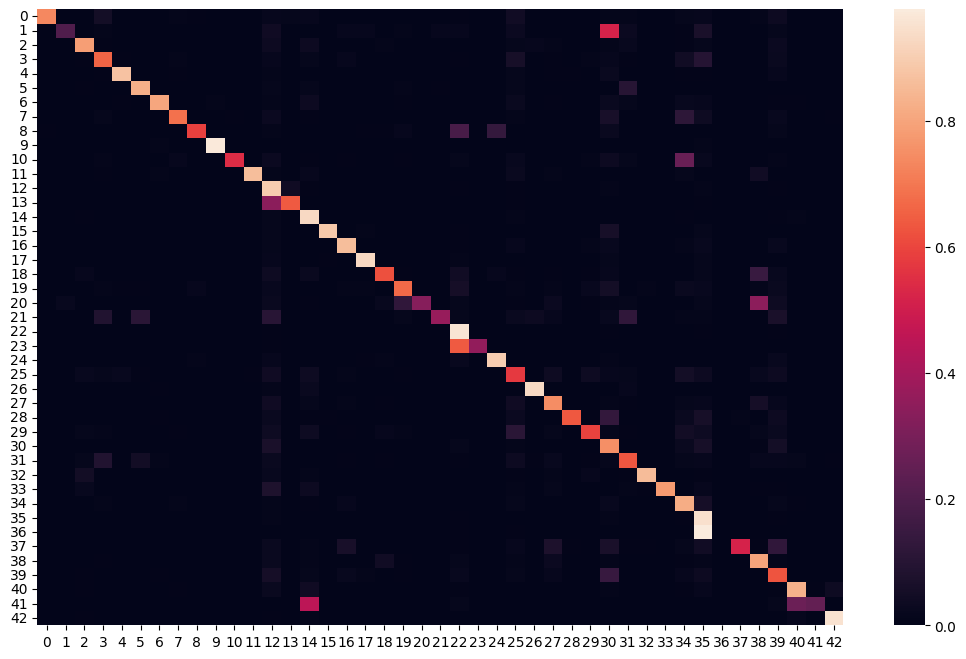

In [26]:
conf_mat = confusion_matrix(y_test, y_pred_classes)

#Normalize confusion_matrix
conf_mat = conf_mat.astype('float')/ conf_mat.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat)

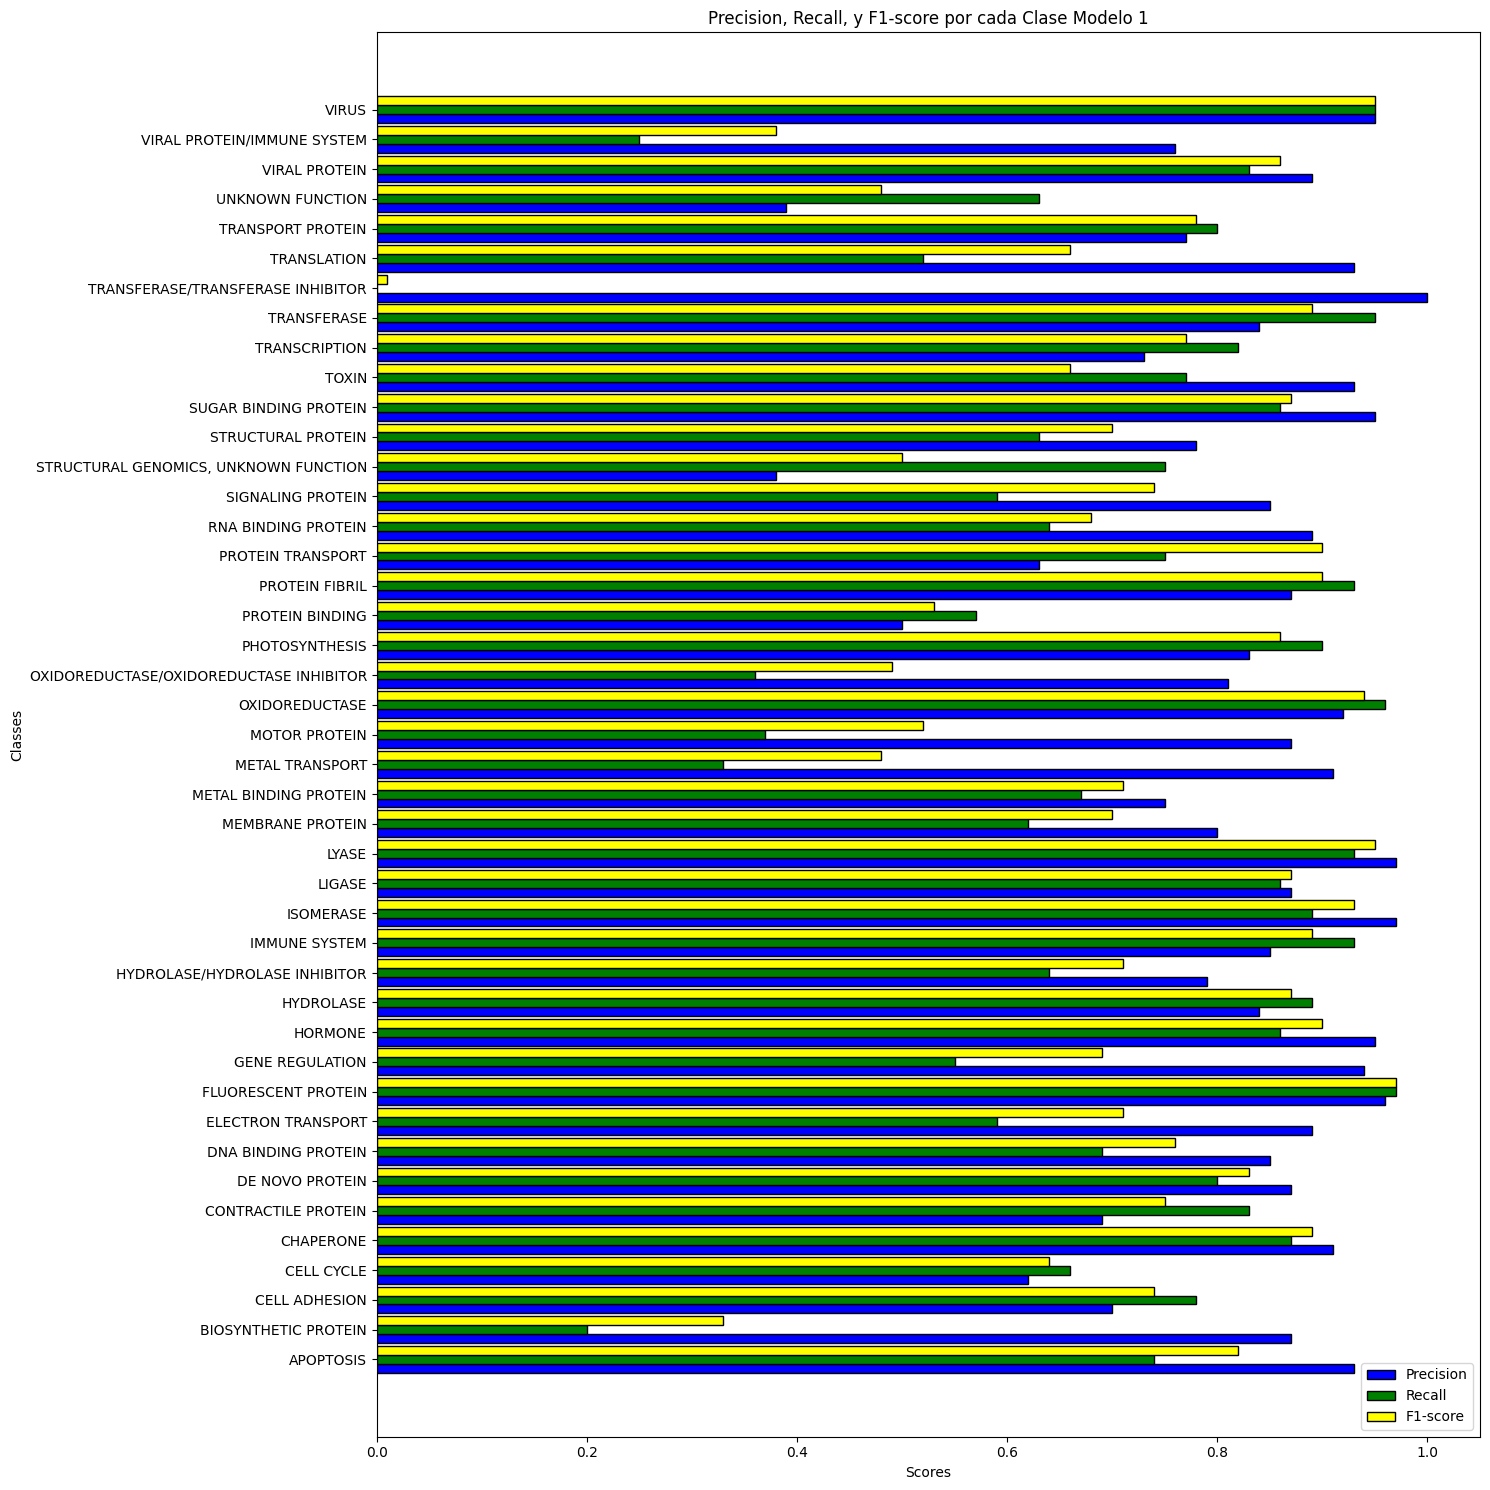

In [17]:
# Definir las clases
classes = [
    "APOPTOSIS", "BIOSYNTHETIC PROTEIN", "CELL ADHESION", "CELL CYCLE", "CHAPERONE", "CONTRACTILE PROTEIN",
    "DE NOVO PROTEIN", "DNA BINDING PROTEIN", "ELECTRON TRANSPORT", "FLUORESCENT PROTEIN", "GENE REGULATION",
    "HORMONE", "HYDROLASE", "HYDROLASE/HYDROLASE INHIBITOR", "IMMUNE SYSTEM", "ISOMERASE", "LIGASE", "LYASE",
    "MEMBRANE PROTEIN", "METAL BINDING PROTEIN", "METAL TRANSPORT", "MOTOR PROTEIN", "OXIDOREDUCTASE",
    "OXIDOREDUCTASE/OXIDOREDUCTASE INHIBITOR", "PHOTOSYNTHESIS", "PROTEIN BINDING", "PROTEIN FIBRIL",
    "PROTEIN TRANSPORT", "RNA BINDING PROTEIN", "SIGNALING PROTEIN", "STRUCTURAL GENOMICS, UNKNOWN FUNCTION",
    "STRUCTURAL PROTEIN", "SUGAR BINDING PROTEIN", "TOXIN", "TRANSCRIPTION", "TRANSFERASE",
    "TRANSFERASE/TRANSFERASE INHIBITOR", "TRANSLATION", "TRANSPORT PROTEIN", "UNKNOWN FUNCTION", "VIRAL PROTEIN",
    "VIRAL PROTEIN/IMMUNE SYSTEM", "VIRUS"
]

# Definir los valores de precisión, recall y f1-score
precision = [
    0.93, 0.87, 0.70, 0.62, 0.91, 0.69, 0.87, 0.85, 0.89, 0.96, 0.94, 0.95, 0.84, 0.79, 0.85, 0.97, 0.87, 0.97, 0.80,
    0.75, 0.91, 0.87, 0.92, 0.81, 0.83, 0.50, 0.87, 0.63, 0.89, 0.85, 0.38, 0.78, 0.95, 0.93, 0.73, 0.84, 1.00, 0.93,
    0.77, 0.39, 0.89, 0.76, 0.95
]

recall = [
    0.74, 0.20, 0.78, 0.66, 0.87, 0.83, 0.80, 0.69, 0.59, 0.97, 0.55, 0.86, 0.89, 0.64, 0.93, 0.89, 0.86, 0.93, 0.62,
    0.67, 0.33, 0.37, 0.96, 0.36, 0.90, 0.57, 0.93, 0.75, 0.64, 0.59, 0.75, 0.63, 0.86, 0.77, 0.82, 0.95, 0.00, 0.52,
    0.80, 0.63, 0.83, 0.25, 0.95
]

f1_score = [
    0.82, 0.33, 0.74, 0.64, 0.89, 0.75, 0.83, 0.76, 0.71, 0.97, 0.69, 0.90, 0.87, 0.71, 0.89, 0.93, 0.87, 0.95, 0.70,
    0.71, 0.48, 0.52, 0.94, 0.49, 0.86, 0.53, 0.90, 0.90, 0.68, 0.74, 0.50, 0.70, 0.87, 0.66, 0.77, 0.89, 0.01, 0.66,
    0.78, 0.48, 0.86, 0.38, 0.95
]

# Colores para las barras
precision_color = 'blue'
recall_color = 'green'
f1_score_color = 'yellow'
bar_edge_color = 'black'
bar_colors = [precision_color, recall_color, f1_score_color]

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(15, 15))

# Crear un array de índices para las barras
index = np.arange(len(classes))

# Ancho de las barras
bar_width = 0.3

# Graficar las barras
bars = []
for i, metric in enumerate([precision, recall, f1_score]):
    bars.append(ax.barh(index + i * bar_width, metric, bar_width, color=bar_colors[i], edgecolor=bar_edge_color))

# Etiquetas, título y leyenda
ax.set_xlabel('Scores')
ax.set_ylabel('Classes')
ax.set_title('Precision, Recall, y F1-score por cada Clase Modelo 1')
ax.set_yticks(index + bar_width)
ax.set_yticklabels(classes)
ax.legend(bars, ['Precision', 'Recall', 'F1-score'])

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## 5.1) Modelo 2

<Axes: >

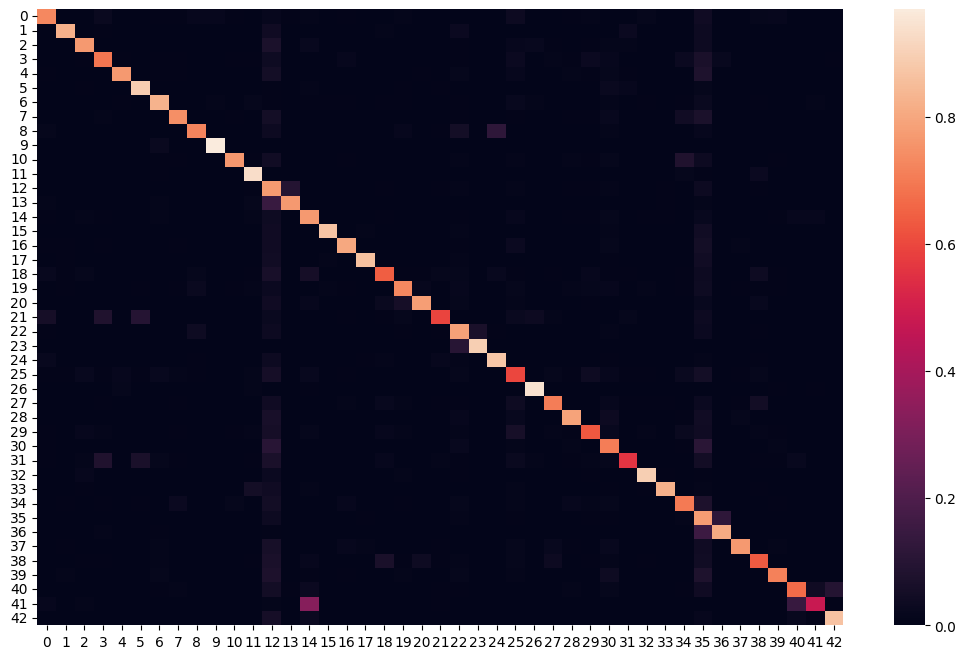

In [14]:
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

#Normalize confusion_matrix
conf_mat_nb = conf_mat_nb.astype('float')/ conf_mat_nb.sum(axis=1)[:, np.newaxis]

# Plot Heat Map
fig , ax = plt.subplots()
fig.set_size_inches(13, 8)
sns.heatmap(conf_mat_nb)

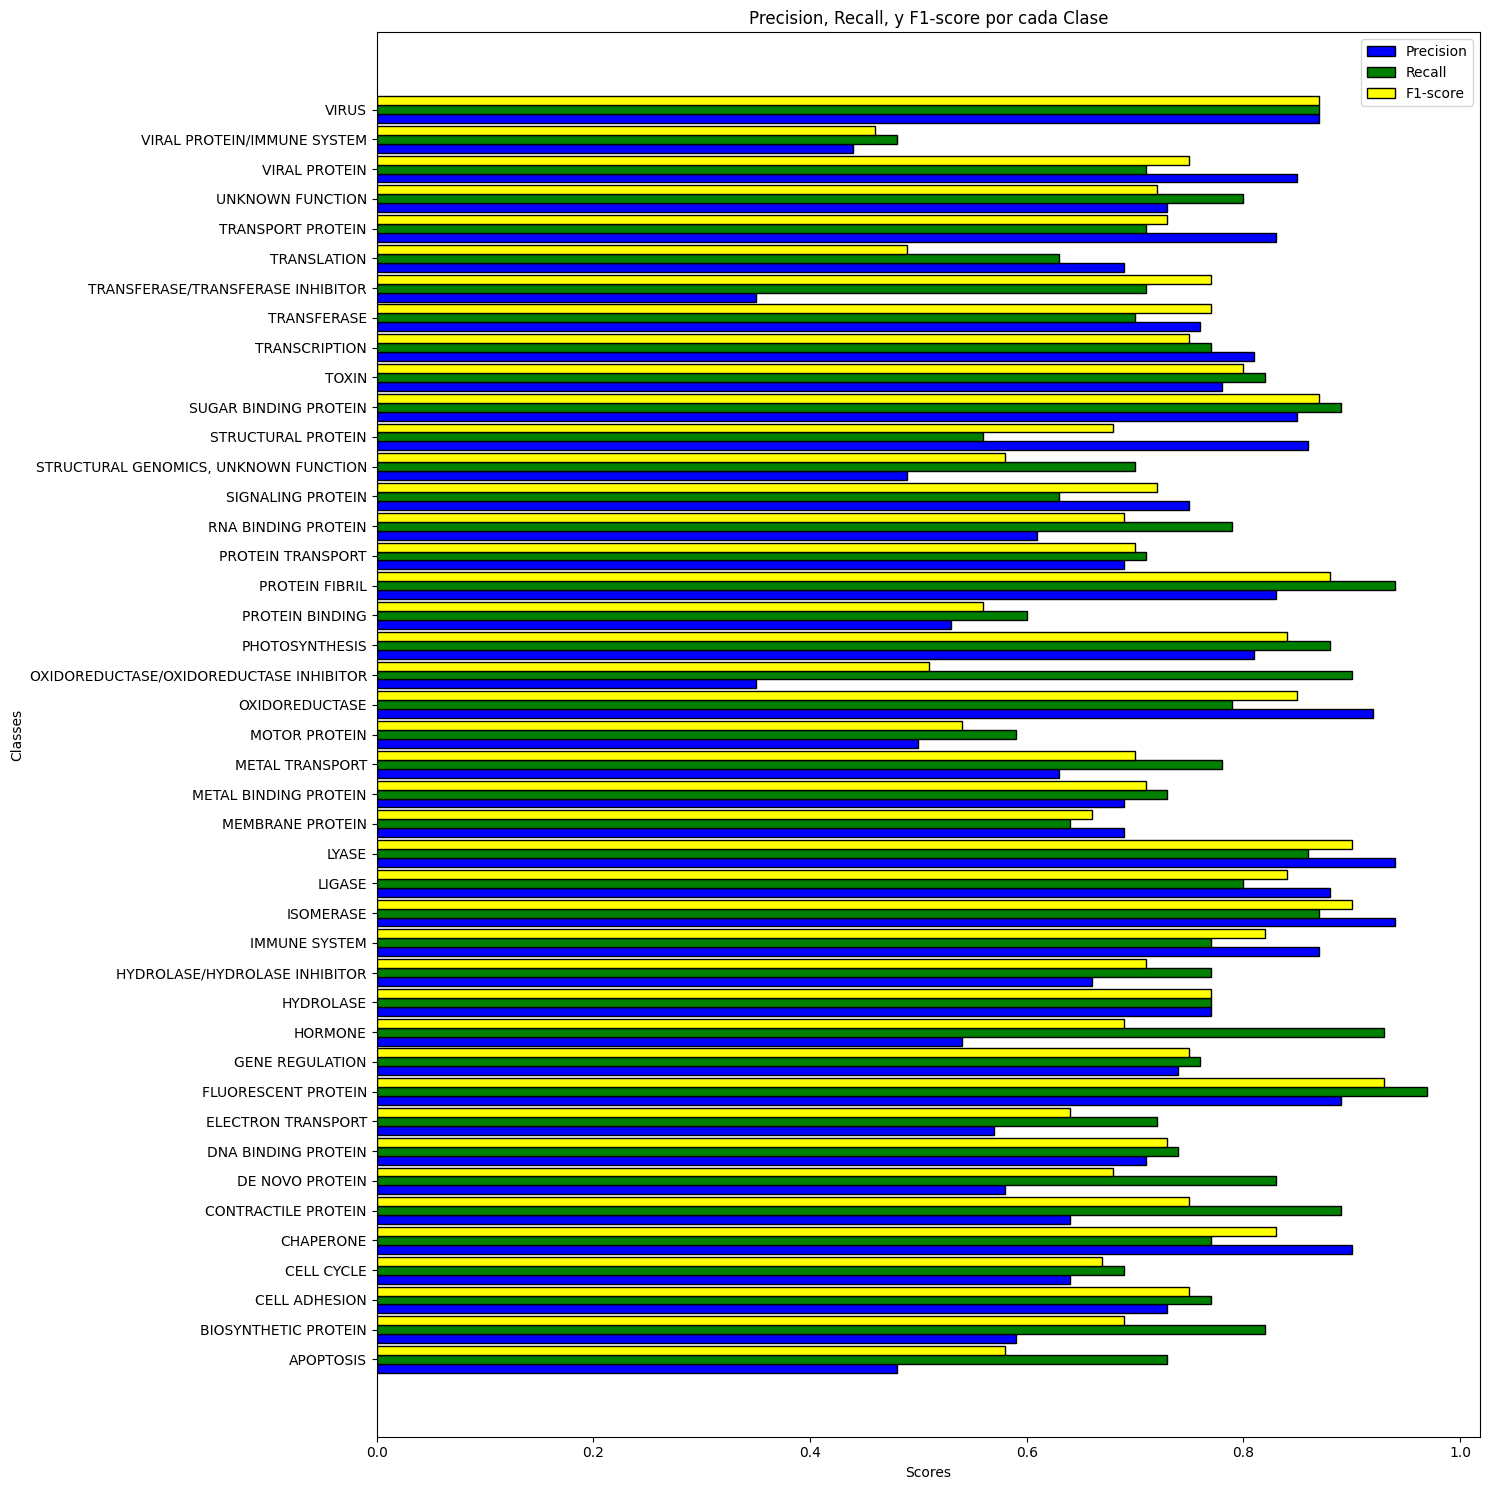

In [16]:
# Resultados del modelo 2
precision_model2 = [
    0.48, 0.59, 0.73, 0.64, 0.90, 0.64, 0.58, 0.71, 0.57, 0.89, 0.74, 0.54, 0.77, 0.66, 0.87, 0.94,
    0.88, 0.94, 0.69, 0.69, 0.63, 0.50, 0.92, 0.35, 0.81, 0.53, 0.83, 0.69, 0.61, 0.75, 0.49, 0.86,
    0.85, 0.78, 0.81, 0.76, 0.35, 0.69, 0.83, 0.73, 0.85, 0.44, 0.87
]

recall_model2 = [
    0.73, 0.82, 0.77, 0.69, 0.77, 0.89, 0.83, 0.74, 0.72, 0.97, 0.76, 0.93, 0.77, 0.77, 0.77, 0.87,
    0.80, 0.86, 0.64, 0.73, 0.78, 0.59, 0.79, 0.90, 0.88, 0.60, 0.94, 0.71, 0.79, 0.63, 0.70, 0.56,
    0.89, 0.82, 0.77, 0.70, 0.71, 0.63, 0.71, 0.80, 0.71, 0.48, 0.87
]

f1_score_model2 = [
    0.58, 0.69, 0.75, 0.67, 0.83, 0.75, 0.68, 0.73, 0.64, 0.93, 0.75, 0.69, 0.77, 0.71, 0.82, 0.90,
    0.84, 0.90, 0.66, 0.71, 0.70, 0.54, 0.85, 0.51, 0.84, 0.56, 0.88, 0.70, 0.69, 0.72, 0.58, 0.68,
    0.87, 0.80, 0.75, 0.77, 0.77, 0.49, 0.73, 0.72, 0.75, 0.46, 0.87
]

# Colores para las barras
precision_color = 'blue'
recall_color = 'green'
f1_score_color = 'yellow'
bar_edge_color = 'black'
bar_colors = [precision_color, recall_color, f1_score_color]

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(15, 15))

# Crear un array de índices para las barras
index = np.arange(len(classes))

# Ancho de las barras
bar_width = 0.3

# Graficar las barras
bars = []
for i, metric in enumerate([precision_model2, recall_model2, f1_score_model2]):
    bars.append(ax.barh(index + i * bar_width, metric, bar_width, color=bar_colors[i], edgecolor=bar_edge_color))

# Etiquetas, título y leyenda
ax.set_xlabel('Scores')
ax.set_ylabel('Classes')
ax.set_title('Precision, Recall, y F1-score por cada Clase Modelo 2')
ax.set_yticks(index + bar_width)
ax.set_yticklabels(classes)
ax.legend(bars, ['Precision', 'Recall', 'F1-score'])

# Mostrar el gráfico
plt.tight_layout()
plt.show()